In [1]:
from __future__ import division
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import time, os, math, warnings
from matplotlib import pyplot

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


### Pre-processing Functions

In [3]:
# Every "looK_back" X points, only one Y, does not predict future. 
def create_timeblock(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)

### Plotting Functions

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def load_data(filename):
    """
    This function reads csv file from the given url and extracts time-series data of oil & water rate,
    pressure, and water cut.
    :param filename: the url of csv file (stored in GitHub)
    :return: t: vector of time; qo: matrix of oil rate in all wells; qo: matrix of water rate in all wells;
            and p: matrix of bottom hole pressure in all wells
    """
    df = pd.read_csv(filename)

    t = df.loc[:, ['TIME']] # Time in simulation: DAY
    t *= 24 # Converting time from DAY to HOUR
    qo = df.loc[:, ['WOPR:P1', 'WOPR:P2', 'WOPR:P3']]
    qw = df.loc[:, ['WWPR:P1', 'WWPR:P2', 'WWPR:P3']]
    p = df.loc[:, ['WBHP:P1', 'WBHP:P2', 'WBHP:P3']]
    wc = df.loc[:, ['WWCT:P1', 'WWCT:P2', 'WWCT:P3']]
    return t, qo, qw, wc, p

def plot_pressure(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_pred_rate(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Flow Rate (STB/d)", fontsize=14)
    plt.title("Flow Rate Well " +str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_rates(t, q, wellname, color, label):
    """This function plots actual flow rates"""
    # Plotting Flow Rate v time
    plt.plot(t, q, color, linewidth=3, label=label)
    plt.xlabel("Time (hours)", fontsize=11)
    plt.ylabel("Flow Rate (STB/D)", fontsize=11)
    plt.title('Flow Rate Well ' + wellname, y=0.82, fontsize=9)
    plt.legend(loc=1, prop=dict(size=8))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q) + 10)
    plt.grid(True)

def plot_pressure_rates(x, y, y_pred, labelname):
    """This function plots both pressure and actual flow rates"""
    plt.figure()
    if labelname=='Training Data':
        color='red'
    else:
        color='green'

    plt.subplot(411)
    plot_pressure(x['TIME'], y, y_pred, labelname, color)

    plt.subplot(412)
    plot_rates(x['TIME'], x['WWPR:P1'], wellname='A', color='blue', label='Water Rate')
    plot_rates(x['TIME'], x['WOPR:P1'], wellname='A', color='green', label='Oil Rate')
    plt.ylim(0, max(max(x['WWPR:P1'].values), max(x['WOPR:P1'].values)) + 10)

    plt.subplot(413)
    plot_rates(x['TIME'], x['WOPR:P2'],wellname='B',color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P2'],wellname='B',color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P2'].values), max(x['WOPR:P2'].values)) + 10)

    plt.subplot(414)
    plot_rates(x['TIME'], x['WOPR:P3'], wellname='C', color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P3'], wellname='C', color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P3'].values), max(x['WOPR:P3'].values)) + 10)

def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()

def plot_loss_comparison(histories):
    plt.figure()
    plt.plot(histories['Simple RNN'].history['val_loss'], linewidth=3, label='Simple RNN')
    plt.plot(histories['GRU'].history['val_loss'], linewidth=3, label='GRU')
    plt.plot(histories['LSTM'].history['val_loss'], linewidth=3, label='LSTM')
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title(' Dev Loss', fontsize=15)
    plt.xlim(0, len(histories['Simple RNN'].history['loss']))
    plt.ylim(0, 0.02)
    plt.show()


### Load Data

In [5]:
t, qo, qw, wc, p = load_data('close_highWC_long.csv')    # self defined funciton, see above


# Flow Rate Prediction

### Pre-processing

WOPR oil flow rate

In [6]:
# Group the input
X_raw = pd.concat([p['WBHP:P1'], p['WBHP:P2'], p['WBHP:P3']], axis=1, join='inner')   # three well pressure
Y_raw = pd.concat([qo['WOPR:P1'], qo['WOPR:P2'], qo['WOPR:P3']], axis=1, join='inner') #three well flow rates

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_raw,
                                                  Y_raw,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and dev sets
dev_fraction = 0.15 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.as_matrix())
x_dev_norm = scaler_x.transform(x_dev_raw.as_matrix())
x_test_norm = scaler_x.transform(x_test_raw.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.as_matrix())
y_dev_norm = scaler_y.transform(y_dev_raw.as_matrix())
y_test_norm = scaler_y.transform(y_test_raw.as_matrix())

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)


# of data:  1235
# of data:  245
# of data:  246
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a fut

In [19]:
y_train.shape

(1235, 3)

In [13]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=400, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}


    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)    
    # equvilent to X=LSTM(512, return_sequences=True)(inputs)   
    X = classifier[method](1024, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    # TimeDistrituted allows you to apply that Dense function across every output at same time
    # three outputs in current case
    # three results at the same time, hence three outputs, not three nodes. 
    X = Dropout(0.4)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X)) # three well flow rates
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = Model(input=inputs, output=[out1, out2, out3])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1], y_dev[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

In [17]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_dev, y_dev, epochs=10, batch_size=300, method='LSTM')

C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
Train on 1235 samples, validate on 245 samples
Epoch 1/10
1235/1235 [==============================] - 20s 16ms/step - loss: 0.2521 - dense_6_loss: 0.1042 - dense_7_loss: 0.0913 - dense_8_loss: 0.0372 - dense_6_mae: 0.2703 - dense_6_accuracy: 0.0000e+00 - dense_7_mae: 0.2764 - dense_7_accuracy: 0.0000e+00 - dense_8_mae: 0.1339 - dense_8_accuracy: 0.0000e+00 - val_loss: 0.0368 - val_dense_6_loss: 0.0212 - val_dense_7_loss: 0.0052 - val_dense_8_loss: 0.0104 - val_dense_6_mae: 0.1349 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0710 - val_dense_7_accuracy: 0.0000e+00 - val_dense_8_mae: 0.0961 - val_dense_8_accuracy: 0.0000e+00
Epoch 2/10
1235/1235 [==============================] - 19s 15ms/step - loss: 0.1678 - dense_6_loss: 0.0418 - dense_7_loss: 0.0623 - dense_8

In [18]:
# Training
y_pred_train_pre = model_LSTM.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_LSTM.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

In [28]:
scaler_x.value

(0, 1)

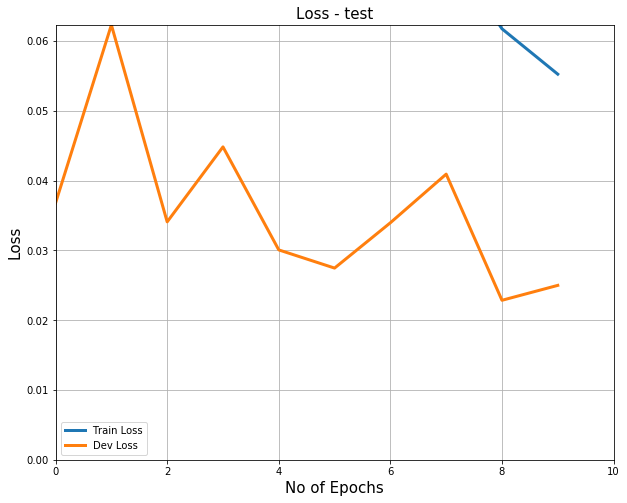

Training Set Score: 0.4418
Dev Set Score: -0.5284
Test Set Score: -14.5872
Training Set MSE: 16130.9760
Dev Set MSE: 10041.2662
Test Set MSE: 7162.3291


In [20]:
plot_loss(history_LSTM, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


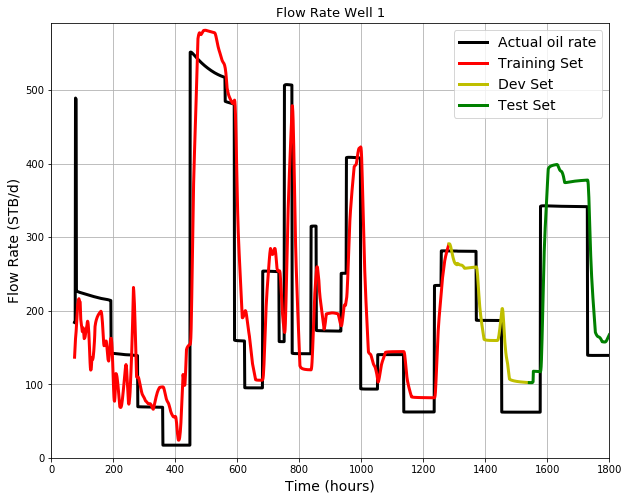

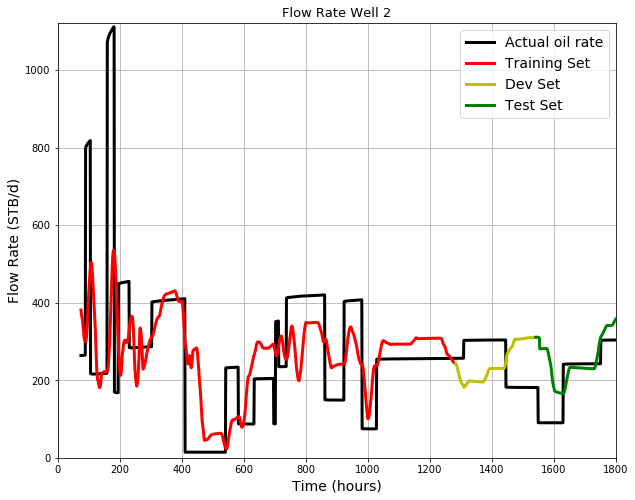

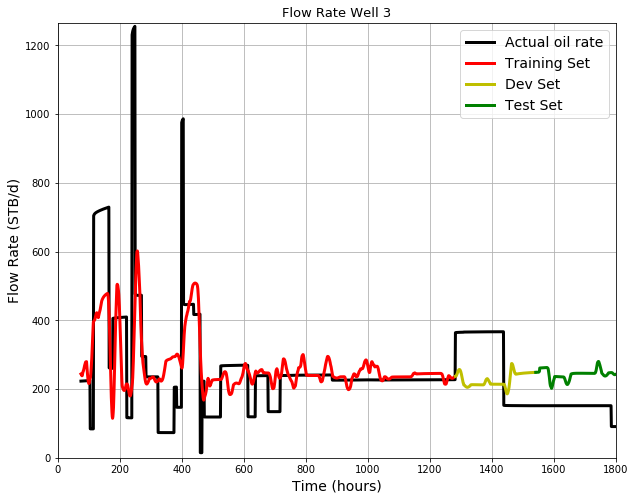

In [30]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

GRU

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Train on 1235 samples, validate on 245 samples
Epoch 1/300
1235/1235 [==============================] - 3s 2ms/step - loss: 0.2403 - dense_6_loss: 0.1006 - dense_7_loss: 0.0844 - dense_8_loss: 0.0553 - dense_6_mean_absolute_error: 0.2688 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.2288 - dense_7_acc: 0.0000e+00 - dense_8_mean_absolute_error: 0.1803 - dense_8_acc: 0.0000e+00 - val_loss: 0.0506 - val_dense_6_loss: 0.0238 - val_dense_7_loss: 0.0071 - val_dense_8_loss: 0.0197 - val_dense_6_mean_absolute_error: 0.1454 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0813 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.1074 - val_dense_8_acc: 0.0000e+00
Epoch 2/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.1467 - dense_6_loss: 0.0449 - dense_7_loss: 0.0535 - dense_8_loss: 0.0483 - dense_6_mean_absolute_error: 0.1712 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.1659 - dense_7_acc: 0.0000e+00 - dense_8_m

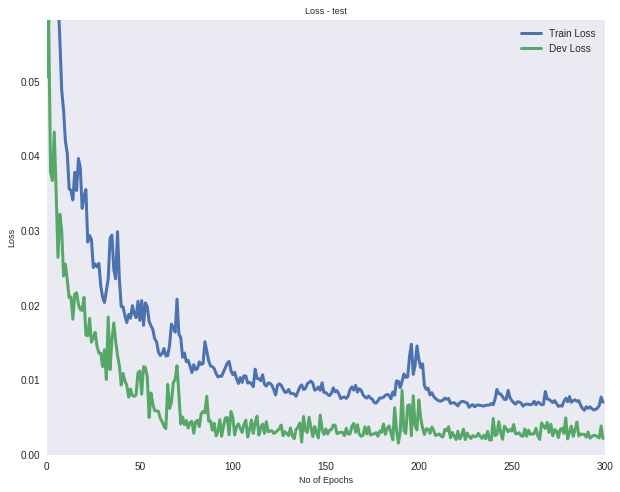

Training Set Score: 0.9465
Dev Set Score: 0.9084
Test Set Score: -2.4083
Training Set MSE: 1489.8051
Dev Set MSE: 725.5548
Test Set MSE: 1072.5453


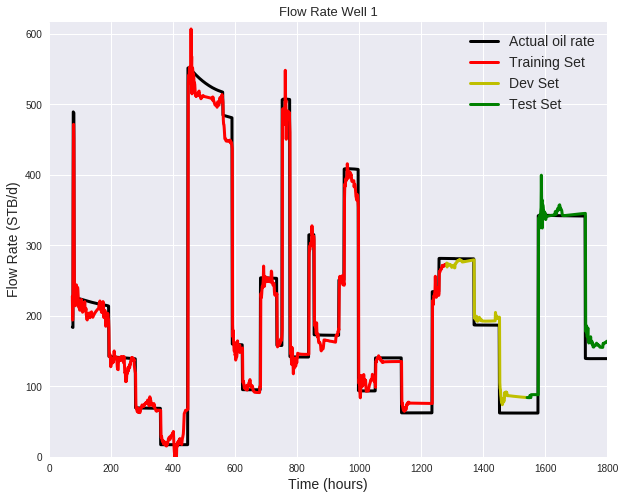

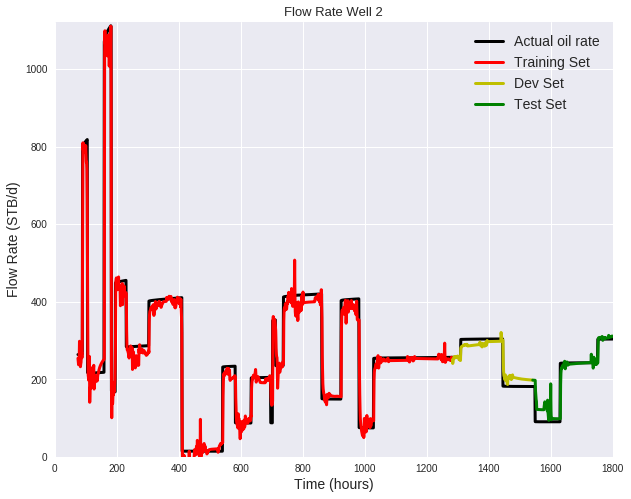

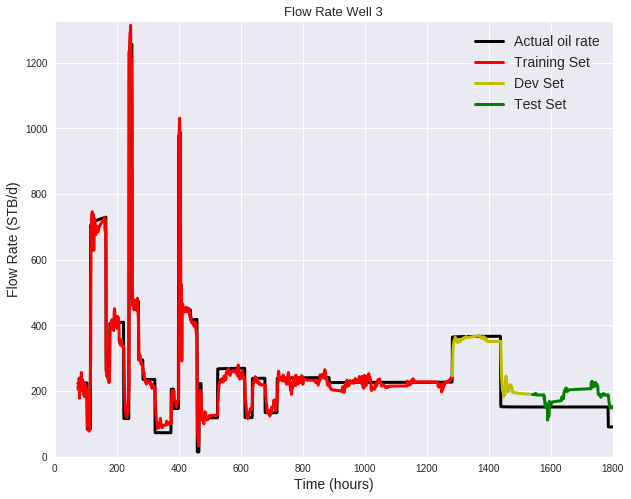

In [20]:
model_GRU, history_GRU = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='GRU')

# Training
y_pred_train_pre = model_GRU.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_GRU.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_GRU.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

plot_loss(history_GRU, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

Simple RNN

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Train on 1235 samples, validate on 245 samples
Epoch 1/300
1235/1235 [==============================] - 2s 1ms/step - loss: 11.8842 - dense_14_loss: 1.5349 - dense_15_loss: 2.8967 - dense_16_loss: 7.4526 - dense_14_mean_absolute_error: 1.0561 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 1.3585 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 2.1191 - dense_16_acc: 8.0972e-04 - val_loss: 5.6431 - val_dense_14_loss: 5.4992 - val_dense_15_loss: 0.1406 - val_dense_16_loss: 0.0034 - val_dense_14_mean_absolute_error: 2.3417 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.3720 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0458 - val_dense_16_acc: 0.0000e+00
Epoch 2/300
1235/1235 [==============================] - 1s 412us/step - loss: 6.3189 - dense_14_loss: 3.9016 - dense_15_loss: 1.3049 - dense_16_loss: 1.1124 - dense_14_mean_absolute_error: 1.7113 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.9307 - dense_15

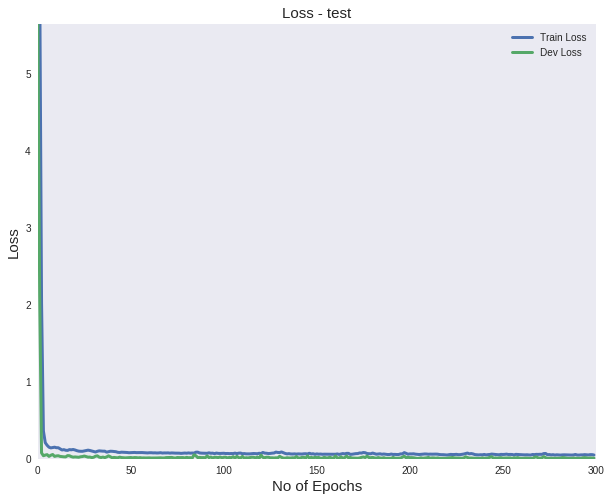

Training Set Score: 0.4156
Dev Set Score: 0.4738
Test Set Score: -11.3533
Training Set MSE: 228710.4070
Dev Set MSE: 56484.3841
Test Set MSE: 68027.2307


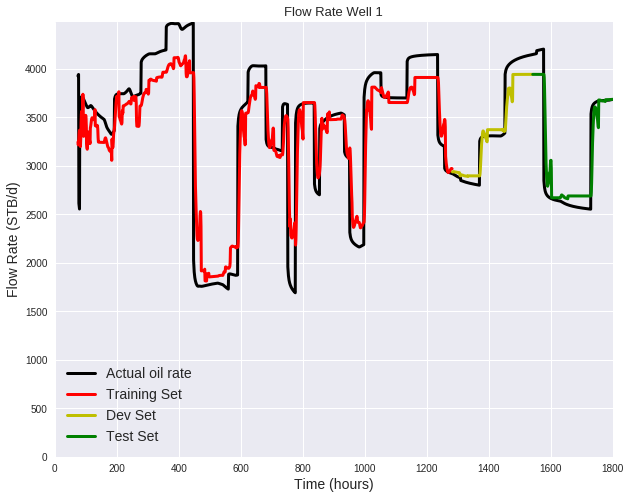

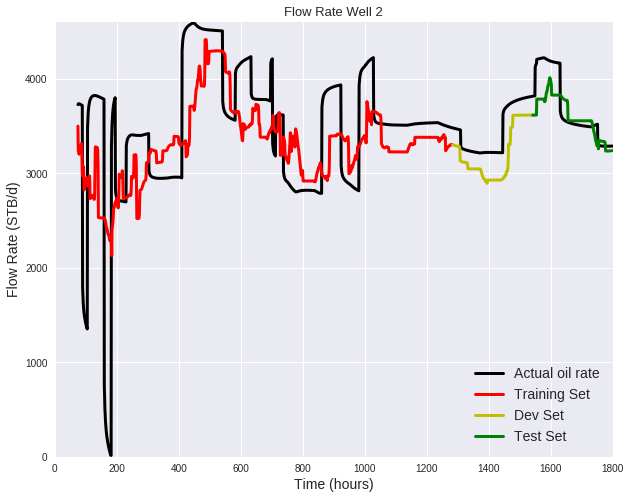

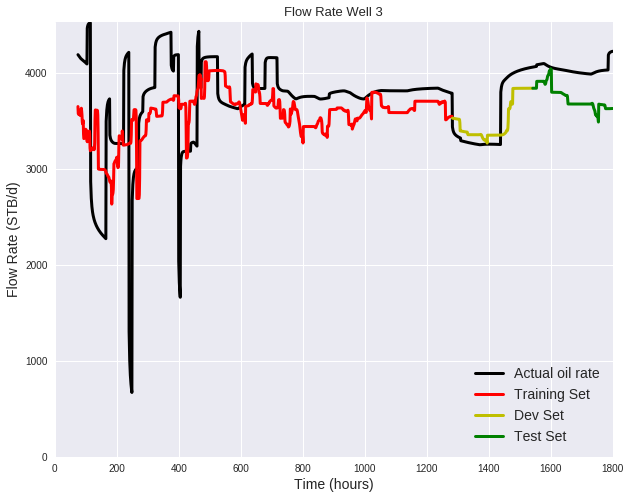

In [40]:
import time
start_time = time.time()
model_RNN, history_RNN = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='Simple RNN')
# Measure running time
print("Completed in %s seconds" % (time.time() - start_time))

# Training
y_pred_train_pre = model_RNN.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_RNN.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_RNN.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

plot_loss(history_RNN, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

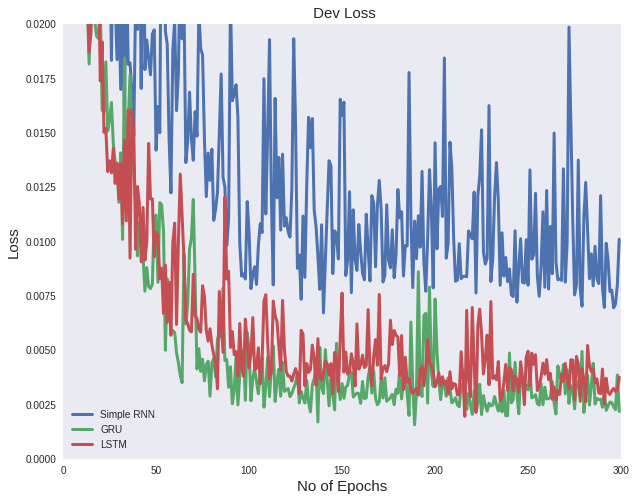

In [39]:
histories = {'Simple RNN': history_RNN,
            'GRU': history_GRU,
            'LSTM': history_LSTM}
plot_loss_comparison(histories)

## BHP Prediction

In [33]:
# Group the input
Y_raw = pd.concat([p['WBHP:P1'], p['WBHP:P2'], p['WBHP:P3']], axis=1, join='inner')
X_raw = pd.concat([qo['WOPR:P1'], qo['WOPR:P2'], qo['WOPR:P3'],
                   qw['WWPR:P1'], qw['WWPR:P2'], qw['WWPR:P3'],
                   wc['WWCT:P1'], wc['WWCT:P2'], wc['WWCT:P3']], axis=1, join='inner')

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_raw,
                                                  Y_raw,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and dev sets
dev_fraction = 0.15 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.as_matrix())
x_dev_norm = scaler_x.transform(x_dev_raw.as_matrix())
x_test_norm = scaler_x.transform(x_test_raw.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.as_matrix())
y_dev_norm = scaler_y.transform(y_dev_raw.as_matrix())
y_test_norm = scaler_y.transform(y_test_raw.as_matrix())

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)

# of data:  1235
# of data:  245
# of data:  246


In [ ]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=400, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}

    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    #X = Dropout(0.6)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = Model(input=inputs, output=[out1, out2, out3])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1], y_dev[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

In [ ]:
model, history = run_model(x_train, y_train, x_dev, y_dev, epochs=1000, batch_size=200, method='LSTM')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Train on 1235 samples, validate on 245 samples
Epoch 1/1000
1235/1235 [==============================] - 4s 3ms/step - loss: 2.9897 - dense_14_loss: 1.3118 - dense_15_loss: 0.6659 - dense_16_loss: 1.0120 - dense_14_mean_absolute_error: 0.7683 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.6346 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.7367 - dense_16_acc: 8.0972e-04 - val_loss: 0.6676 - val_dense_14_loss: 0.2246 - val_dense_15_loss: 0.2233 - val_dense_16_loss: 0.2197 - val_dense_14_mean_absolute_error: 0.4454 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.4682 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.4584 - val_dense_16_acc: 0.0000e+00
Epoch 2/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.3079 - dense_14_loss: 0.1313 - dense_15_loss: 0.0967 - dense_16_loss: 0.0799 - dense_14_mean_absolute_error: 0.3019 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.2598 - dense_15_

In [29]:
# Training
y_pred_train_pre = model.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

NameError: name 'model' is not defined

In [ ]:
plot_loss(history, title='test')
plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

NameError: ignored

In [ ]:


for i in range(y_act.shape[1]):
    plot_pressure(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('plot_LSTM_512_1024_lb25_well_' + str(i))

NameError: ignored

In [ ]:
plot_model(model)

ImportError: ignored

In [ ]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

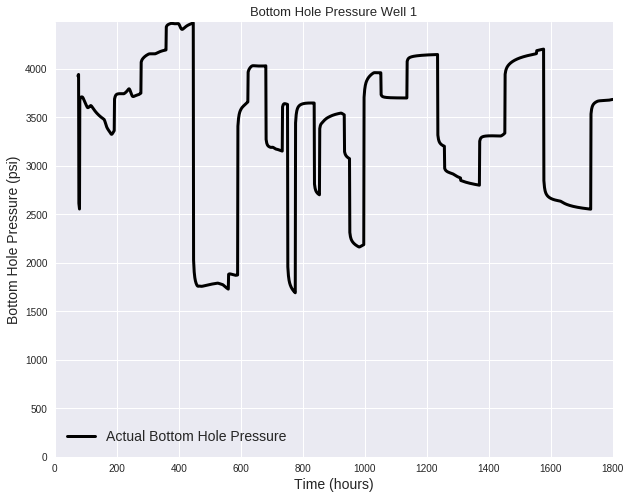

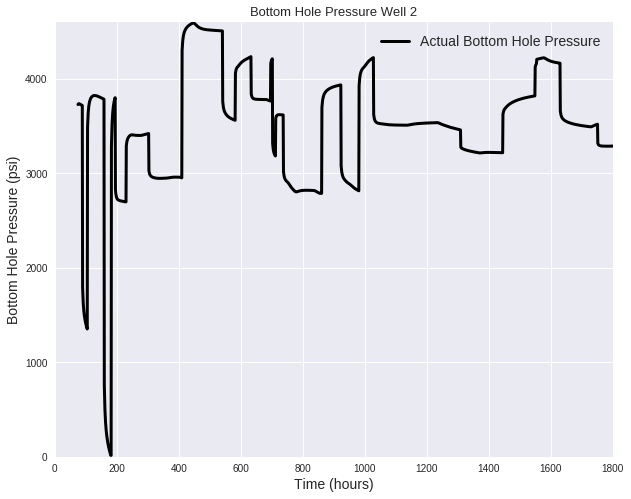

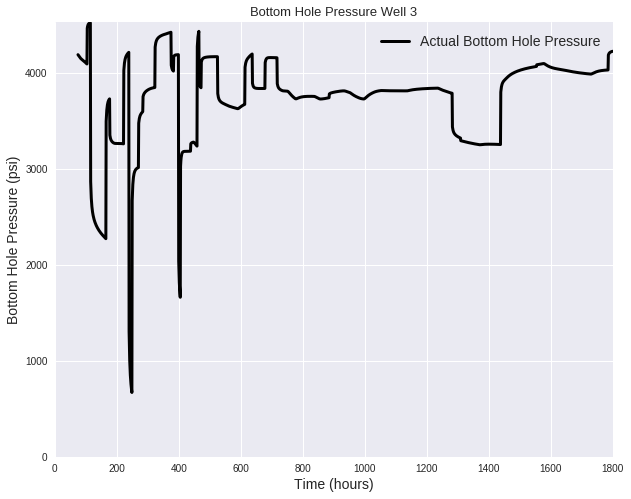

In [37]:
def plot_pressure_actual(t, q_actual, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual Bottom Hole Pressure')

    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q_actual) + 10)
    plt.grid(True)

for i in range(y_act.shape[1]):
    plot_pressure_actual(t[-len(y_act):].as_matrix(),
                   y_act[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    #plt.savefig('plot_LSTM_512_1024_lb25_well_' + str(i))

In [ ]:
# Training

y_train_act = scaler_y.inverse_transform(y_train)

# Dev

y_dev_act = scaler_y.inverse_transform(y_dev)

# Test

y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])


In [ ]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')
!ls drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > drive/created.txt

Files in Drive:
2016 NZ
20171219_082049.mp4
Achievements
Colab Notebooks
Consulting
CS230
C:\Users\E460\PycharmProjects\untitled3\Hackathon
Documents
IM
Intern_Full Time 2018
Misc
Peru 2017
Readings
Resume__Tita Ristanto.pdf
Resume__Tita Ristanto - Tita Ristanto.pdf
Selection
Sequoia Yosemite 2017
Stanford
SUN Energy
Trip
Untitled spreadsheet.ods
Untitled spreadsheet.ods (795d2dd5)
